# DCGAN

In [36]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, LeakyReLU, Layer, Conv2D, BatchNormalization, Flatten, Conv2DTranspose

## Generator

In [44]:
class Generator(Model):
    def __init__(self):
        super().__init__()
        self.dense = Dense(7*7*512, use_bias=False, input_shape=(100, ))
        self.bn = BatchNormalization()
        self.lrelu = LeakyReLU()
        
        self.deconv1 = Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False)
        self.bn1 = BatchNormalization()
        self.lrelu1 = LeakyReLU()
        
        self.deconv2 = Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False)
        self.bn2 = BatchNormalization()
        self.lrelu2 = LeakyReLU()
        
        self.deconv3 = Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same')
        
    def call(self, x, training=None, mask=None):
        h = self.lrelu(self.bn(self.dense(x), training))
        h = tf.reshape(h, (-1, 7, 7, 512))
        h = self.lrelu1(self.bn1(self.deconv1(h), training))
        h = self.lrelu2(self.bn2(self.deconv2(h), training))
        return self.deconv3(h)

## Discriminator

In [45]:
class Discriminator(Model):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2D(64, (5, 5), strides=(2, 2), padding='same')
        self.bn1 = BatchNormalization()
        self.lrelu1 = LeakyReLU()
        
        self.conv2 = Conv2D(128, (5, 5), strides=(2, 2), padding='same')
        self.bn2 = BatchNormalization()
        self.lrelu2 = LeakyReLU()
        
        self.flatten = Flatten()
        self.dense = Dense(1, activation='sigmoid')

    def call(self, x, training=None, mask=None):
        h = self.lrelu1(self.bn1(self.conv1(x), training))
        h = self.lrelu2(self.bn2(self.conv2(h), training))
        return self.dense(h)

## Datasets

In [39]:
dataset = tfds.load(name='fashion_mnist', split=tfds.Split.TRAIN)
dataset = dataset.map(lambda x: tf.cast(x['image'], tf.float32) / 255.0).batch(32)

## Model, Optimizers

In [40]:
generator = Generator()
discriminator = Discriminator()

optim_d = tf.optimizers.Adam(1e-4)
optim_g = tf.optimizers.Adam(1e-4)

d_mean = tf.metrics.Mean()
g_mean = tf.metrics.Mean()

## Losses

In [41]:
def discriminator_loss(d_real, d_fake):
    real_loss = tf.keras.losses.BinaryCrossentropy()(tf.ones_like(d_real), d_real)
    fake_loss = tf.keras.losses.BinaryCrossentropy()(tf.zeros_like(d_fake), d_fake)
    return real_loss + fake_loss

def generator_loss(d_fake):
    return tf.keras.losses.BinaryCrossentropy()(tf.ones_like(d_fake), d_fake)

## Training Step

In [46]:
@tf.function
def train_step(image, optim_d, optim_g):
    with tf.GradientTape() as tape_d, tf.GradientTape() as tape_g: 
        z = tf.random.normal([32, 100])
        g = generator(z, training=True)
        
        d_real = discriminator(image, training=True)
        d_fake = discriminator(g, training=True)
        
        d_loss = discriminator_loss(d_real, d_fake)
        g_loss = generator_loss(d_fake)
        
        gradients_d = tape_d.gradient(d_loss, discriminator.trainable_weights)
        gradients_g = tape_g.gradient(g_loss, generator.trainable_weights)
    
    optim_d.apply_gradients(zip(gradients_d, discriminator.trainable_weights))
    optim_g.apply_gradients(zip(gradients_g, generator.trainable_weights))
    return d_loss, g_loss

## Training Loop

epoch: 1, d_loss: 1.0271542072296143, g_loss: 0.9248836636543274


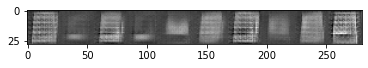

epoch: 2, d_loss: 1.149886965751648, g_loss: 0.8626899719238281
epoch: 3, d_loss: 1.1432371139526367, g_loss: 0.882472813129425
epoch: 4, d_loss: 1.1186882257461548, g_loss: 0.9112317562103271
epoch: 5, d_loss: 1.137078046798706, g_loss: 0.9078376889228821
epoch: 6, d_loss: 1.1391767263412476, g_loss: 0.9118293523788452
epoch: 7, d_loss: 1.1448743343353271, g_loss: 0.9135909676551819
epoch: 8, d_loss: 1.1542208194732666, g_loss: 0.9120070934295654
epoch: 9, d_loss: 1.15548574924469, g_loss: 0.9156975150108337
epoch: 10, d_loss: 1.135794758796692, g_loss: 0.9365651607513428
epoch: 11, d_loss: 1.137747883796692, g_loss: 0.9385514259338379


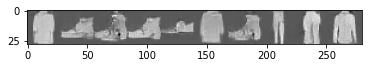

epoch: 12, d_loss: 1.1355178356170654, g_loss: 0.9470869302749634
epoch: 13, d_loss: 1.1292792558670044, g_loss: 0.95524001121521
epoch: 14, d_loss: 1.1255691051483154, g_loss: 0.9645335674285889
epoch: 15, d_loss: 1.1300675868988037, g_loss: 0.9629111886024475
epoch: 16, d_loss: 1.1240307092666626, g_loss: 0.9694753885269165
epoch: 17, d_loss: 1.1256954669952393, g_loss: 0.9761530160903931
epoch: 18, d_loss: 1.1252362728118896, g_loss: 0.9792373776435852
epoch: 19, d_loss: 1.120303988456726, g_loss: 0.9859956502914429
epoch: 20, d_loss: 1.110892653465271, g_loss: 0.9953796863555908
epoch: 21, d_loss: 1.1231008768081665, g_loss: 0.9900747537612915


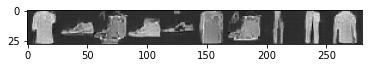

epoch: 22, d_loss: 1.1272940635681152, g_loss: 0.9909136891365051
epoch: 23, d_loss: 1.1176561117172241, g_loss: 1.0021426677703857
epoch: 24, d_loss: 1.128824234008789, g_loss: 0.9947105646133423
epoch: 25, d_loss: 1.1221216917037964, g_loss: 0.999567449092865
epoch: 26, d_loss: 1.1261473894119263, g_loss: 1.002928376197815
epoch: 27, d_loss: 1.1261422634124756, g_loss: 1.0004487037658691
epoch: 28, d_loss: 1.1249327659606934, g_loss: 1.0057111978530884
epoch: 29, d_loss: 1.1205644607543945, g_loss: 1.0077792406082153
epoch: 30, d_loss: 1.1215702295303345, g_loss: 1.0134894847869873
epoch: 31, d_loss: 1.1240161657333374, g_loss: 1.011488437652588


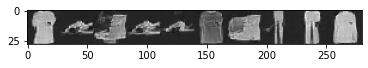

epoch: 32, d_loss: 1.126354694366455, g_loss: 1.0108577013015747
epoch: 33, d_loss: 1.1335824728012085, g_loss: 1.0044724941253662
epoch: 34, d_loss: 1.1344436407089233, g_loss: 1.0052964687347412
epoch: 35, d_loss: 1.1375402212142944, g_loss: 1.0064460039138794
epoch: 36, d_loss: 1.1329978704452515, g_loss: 1.0097132921218872
epoch: 37, d_loss: 1.1384596824645996, g_loss: 1.0060487985610962
epoch: 38, d_loss: 1.1356536149978638, g_loss: 1.0102547407150269
epoch: 39, d_loss: 1.135846734046936, g_loss: 1.0112656354904175
epoch: 40, d_loss: 1.1408231258392334, g_loss: 1.0072139501571655
epoch: 41, d_loss: 1.1416054964065552, g_loss: 1.0063878297805786


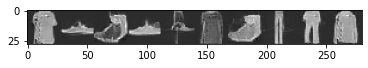

epoch: 42, d_loss: 1.136425495147705, g_loss: 1.0128493309020996
epoch: 43, d_loss: 1.1402946710586548, g_loss: 1.0087896585464478
epoch: 44, d_loss: 1.1419421434402466, g_loss: 1.009145736694336
epoch: 45, d_loss: 1.1370797157287598, g_loss: 1.0135951042175293
epoch: 46, d_loss: 1.1295305490493774, g_loss: 1.0208643674850464
epoch: 47, d_loss: 1.1476608514785767, g_loss: 1.0088467597961426
epoch: 48, d_loss: 1.1420801877975464, g_loss: 1.0149205923080444
epoch: 49, d_loss: 1.1401499509811401, g_loss: 1.0150630474090576
epoch: 50, d_loss: 1.1361186504364014, g_loss: 1.0232547521591187
epoch: 51, d_loss: 1.1435213088989258, g_loss: 1.0152966976165771


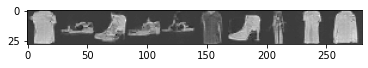

epoch: 52, d_loss: 1.1333808898925781, g_loss: 1.0235604047775269
epoch: 53, d_loss: 1.1417720317840576, g_loss: 1.0195754766464233
epoch: 54, d_loss: 1.147041916847229, g_loss: 1.0155479907989502
epoch: 55, d_loss: 1.1527512073516846, g_loss: 1.0095142126083374
epoch: 56, d_loss: 1.145195722579956, g_loss: 1.0190247297286987
epoch: 57, d_loss: 1.145256757736206, g_loss: 1.0172377824783325
epoch: 58, d_loss: 1.1395832300186157, g_loss: 1.0280970335006714
epoch: 59, d_loss: 1.1478899717330933, g_loss: 1.0183024406433105
epoch: 60, d_loss: 1.144291639328003, g_loss: 1.0190080404281616
epoch: 61, d_loss: 1.1413304805755615, g_loss: 1.022417664527893


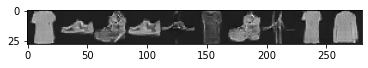

epoch: 62, d_loss: 1.1343836784362793, g_loss: 1.0323041677474976
epoch: 63, d_loss: 1.140735387802124, g_loss: 1.0278111696243286
epoch: 64, d_loss: 1.1433840990066528, g_loss: 1.0249921083450317
epoch: 65, d_loss: 1.1437970399856567, g_loss: 1.0226497650146484
epoch: 66, d_loss: 1.1361949443817139, g_loss: 1.0348596572875977
epoch: 67, d_loss: 1.1398508548736572, g_loss: 1.0308645963668823
epoch: 68, d_loss: 1.1436848640441895, g_loss: 1.0245639085769653
epoch: 69, d_loss: 1.150321125984192, g_loss: 1.0241528749465942
epoch: 70, d_loss: 1.1549208164215088, g_loss: 1.0203197002410889
epoch: 71, d_loss: 1.1587423086166382, g_loss: 1.0173077583312988


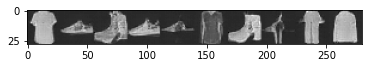

epoch: 72, d_loss: 1.1605770587921143, g_loss: 1.01154363155365
epoch: 73, d_loss: 1.1564160585403442, g_loss: 1.0135083198547363
epoch: 74, d_loss: 1.1667619943618774, g_loss: 1.0057181119918823
epoch: 75, d_loss: 1.1550992727279663, g_loss: 1.0155080556869507
epoch: 76, d_loss: 1.1584833860397339, g_loss: 1.013152837753296
epoch: 77, d_loss: 1.1666616201400757, g_loss: 1.0075129270553589
epoch: 78, d_loss: 1.1565618515014648, g_loss: 1.0157359838485718
epoch: 79, d_loss: 1.1552259922027588, g_loss: 1.0172587633132935
epoch: 80, d_loss: 1.1652836799621582, g_loss: 1.0118542909622192
epoch: 81, d_loss: 1.1726316213607788, g_loss: 1.0024383068084717


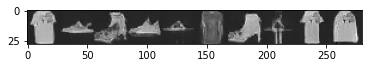

epoch: 82, d_loss: 1.1665321588516235, g_loss: 1.004236102104187
epoch: 83, d_loss: 1.159893274307251, g_loss: 1.0103050470352173
epoch: 84, d_loss: 1.1626702547073364, g_loss: 1.0157032012939453
epoch: 85, d_loss: 1.1580684185028076, g_loss: 1.016022801399231
epoch: 86, d_loss: 1.1610788106918335, g_loss: 1.0144057273864746
epoch: 87, d_loss: 1.1754872798919678, g_loss: 1.0014715194702148
epoch: 88, d_loss: 1.1668078899383545, g_loss: 1.0087131261825562
epoch: 89, d_loss: 1.17437744140625, g_loss: 0.9983136057853699
epoch: 90, d_loss: 1.1645268201828003, g_loss: 1.010830283164978
epoch: 91, d_loss: 1.1692098379135132, g_loss: 1.0120196342468262


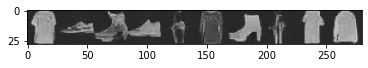

epoch: 92, d_loss: 1.1656336784362793, g_loss: 1.0078641176223755
epoch: 93, d_loss: 1.1781470775604248, g_loss: 1.0007926225662231
epoch: 94, d_loss: 1.1682524681091309, g_loss: 1.0058352947235107
epoch: 95, d_loss: 1.177818775177002, g_loss: 0.9976116418838501
epoch: 96, d_loss: 1.1792585849761963, g_loss: 0.9954614639282227
epoch: 97, d_loss: 1.1804991960525513, g_loss: 0.9982730746269226
epoch: 98, d_loss: 1.1741230487823486, g_loss: 0.9978098273277283
epoch: 99, d_loss: 1.1786153316497803, g_loss: 0.9997532367706299
epoch: 100, d_loss: 1.1888761520385742, g_loss: 0.986362636089325


In [47]:
sample_z = tf.random.normal([10, 100])
for epoch in range(100):
    for image in dataset:
        d_loss, g_loss = train_step(image, optim_d, optim_g)

        d_mean.update_state(d_loss)
        g_mean.update_state(g_loss)

    print('epoch: {}, d_loss: {}, g_loss: {}'.format(epoch+1, d_mean.result(), g_mean.result()))
    
    if epoch % 10 == 0:
        img_list = list()
        sample_img = generator(sample_z)
        for idx in range(sample_img.shape[0]):
            img_list.append(sample_img[idx][:, :, 0])
        img = np.concatenate(img_list, axis=1)
        plt.imshow(img, cmap='gray')
        plt.show()

    d_mean.reset_states()
    g_mean.reset_states()